# Network measurement laboratory - report 4


## Introduction

This assignment aims to analyze the output of *Tstat*, a free open-source passive network monitoring tool, while it was monitoring traffic in the Politecnico's internal network in 2015. 
The first Task, common to all working groups, targets the analysis of TCP connections in a general way while the second Task is group specific and aims to a deeper investigation of a given webservice. For us, the chosen webservice is **Spotify**.

## Task 1



### 1.1

For this exercise we needed to compute the number of *local* clients' TCP connections directed towards all the unique services matching the string _*facebbok.com_ and to plot them in a barplot. Moreover we were asked to plot them in decreasing order and only the top-20. The match has been done considering first what reported in column 127 (namely *fqdn:127*), then, in the case of no match, column 131 (namely *http_hostname:131*), 116 (namely *c_tls_SNI:116*) and 117 (namely *s_tls_SCN:117*) in this sequential order.

In order to fulfill the requirements some lines of code must be added. First the necessary libraries must be imported (*pandas* and *matplotlib*) and we also defined two methods which had to be used within *pandas.DataFrame.apply()* method and which are very useful to obtain the wanted results.

In [1]:
# Import useful libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define useful methods to be used within pandas.DataFrame.apply() method
def find_match(row):
    
    string = 'facebook.com'
    
    if string in row['fqdn:127']:
        return row['fqdn:127']
    
    elif string in row['http_hostname:131']:
        return row['http_hostname:131']
    
    elif string in row['c_tls_SNI:116']:
        return row['c_tls_SNI:116']
    
    else :
        return row['s_tls_SCN:117']
    

def find_match_regex(row):
    
    string = 'facebook'
    
    if string in row['fqdn:127']:
        return row['fqdn:127']
    
    elif string in row['http_hostname:131']:
        return row['http_hostname:131']
    
    elif string in row['c_tls_SNI:116']:
        return row['c_tls_SNI:116']
    
    else :
        return row['s_tls_SCN:117']

Once the libraries are correctly imported and the methods successfully defined, we can proceed to import the file. Due to its huge dimensions, it is unfeasible to load it at once. Therefore, we proceed analyzing it in chunks of 100000 rows.

In [3]:
# Read file CSV
# dataf = pd.read_csv('log_tcp_complete.xz', sep=' ', nrows=100000)    # used for preliminary results
df_iter = pd.read_csv('log_tcp_complete.xz', sep=" ", iterator=True, chunksize=100000)

# Filter DataFrame for "/*facebook.com"
fb_string = '/*facebook.com'        # define string to be matched
fb_dataf = pd.DataFrame()           # define new dataframe to be used for evaluations
tmp = pd.DataFrame()                # define support dataframe

for chunk in df_iter:
    tmp = chunk[(chunk['c_isint:38'] == 1) &
                ((chunk['fqdn:127'].str.contains(fb_string)) |
                 (chunk['http_hostname:131'].str.contains(fb_string)) |
                 (chunk['c_tls_SNI:116'].str.contains(fb_string)) |
                 (chunk['s_tls_SCN:117'].str.contains(fb_string))
               )]
    fb_dataf = pd.concat([fb_dataf, tmp])
    
# print(fb_dataf)

For every chunk of read file we filter it according to the previously mentioned parameters. Thanks to `chunk['c_isint:38'] == 1` in fact, we select only internal clients in the network and with the subsequent lines of code we search for those connections which have a match for the desired string in one of the 4 columns of interest.
Then, we apply to each row of the filtered dataframe (`DataFrame.apply()`) the previously defined method `find_match()`, which returns a string of services names including the string _*facebbok.com_. This is useful because we then can add this list of names to our dataframe, in order to simplify the analysis and the plot.

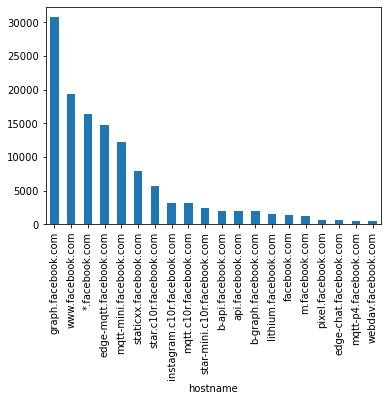

In [4]:
new_col = fb_dataf.apply(find_match, axis=1)
# new_col
fb_dataf.insert(len(fb_dataf.columns), 'hostname', new_col)
# fb_dataf 

# Group and plot
fb_service = fb_dataf.groupby(['hostname']).size()
# fb_service
barplot = fb_service.sort_values(ascending=False).head(20).plot(kind='bar')

Once added the new column to the dataframe, we can then use the method `DataFrame.groupby()` to group them according to some parameter. Since we are asked to find the number of distinct services to which internal hosts are connected to, we group them according to the newly created column *hostname*. In this case we want to know the total number of connections towards each service, therefore we exploit the method `size()` to retrieve it. Afterwards we plot the 20 most used services in descending order using bars.

Observing the plot the service with the most TCP connections is *graph.facebook.com*. By a deeper investigation on what the domain represented it resulted to be:
>The Graph API is the primary way to get data into and out of the Facebook platform. It's an HTTP-based API that apps can use to programmatically query data, post new stories, manage ads, upload photos, and perform a wide variety of other tasks. - *https://developers.facebook.com/docs/graph-api/overview*

Consequently, the reason why it has the most connections becomes clear. 
Surprisngly for us, it has more than 10000 more connections than the main service *www.facebook.com*. Among the other services depicted in the plot it is interesting the presence in the first positions of *edge-mqtt.facebook.com*, *mqtt-mini.facebook.com*, *staticxx.facebook.com* and *star.c10r.facebook.com* which are Facebook's trackers: the sum of all of them reaches more than 40000 connections! Moreover even after these ones there are some others reported in the plot, meaning that a great part of the traffic between clients and Facebook's services implies a lot of tracking, which may not be something wanted nor safe for the users. Then, we can also observe some traffic to some *Instagram* service (through Facebook domain) and some other Facebook's APIs services.

Afterwards, we proceed to test the regex concept making the experiment again, but using _\*facebook\*_ as string for the search and the method `find_match_regex()` defined previously to obtain more matches in the dataframe.

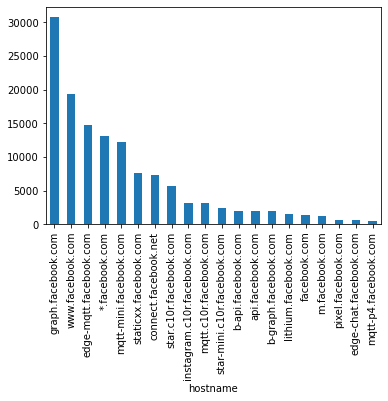

In [4]:
df_iter = pd.read_csv('log_tcp_complete.xz', sep=" ", iterator=True, chunksize=100000)

# Filter DataFrame for "/*facebook*"
fb_string_reg = '/*facebook*'
fb_dataf_reg = pd.DataFrame()           # define new dataframe to be used for evaluations
tmp = pd.DataFrame()                    # define support dataframe

for chunk in df_iter:
    tmp = chunk[(chunk['c_isint:38'] == 1) &
               ((chunk['fqdn:127'].str.contains(fb_string_reg)) |
                (chunk['http_hostname:131'].str.contains(fb_string_reg)) |
                (chunk['c_tls_SNI:116'].str.contains(fb_string_reg)) |
                (chunk['s_tls_SCN:117'].str.contains(fb_string_reg))
               )]
    fb_dataf_reg = pd.concat([fb_dataf_reg, tmp])
    
# print(fb_dataf)

new_col = fb_dataf_reg.apply(find_match_regex, axis=1)
# new_col
fb_dataf_reg.insert(len(fb_dataf_reg.columns), 'hostname', new_col)
# fb_dataf_reg 

# Group and plot
fb_service_reg = fb_dataf_reg.groupby(['hostname']).size()
# fb_service
barplot_reg = fb_service_reg.sort_values(ascending=False).head(20).plot(kind='bar')

With respect to the previous result there are not many changes. The most significant ones are the presence of the service *connect.facebook.net* which was previously excluded due to its domain *.net* and the exchange in position between the services *edge-mqtt.facebook.com* and _\*.facebook.com_. While the first difference is indeed significant since it shows almost 10000 further TCP connections that were previously filtered out, the second difference is marginal.
Therefore, we can deduce that the way we filter the data is ideed a crucial point: we do not want to exclude significant numbers of connections being too strict with search parameters but also being too loose we risk to have much more un-needed data.

ALTRI COMMENTI SUL REGEX?

### 1.2
For this exercise we have to find the top-15 most used services without any filter on local client nor service and plot them using again a descending order bar plot

In order to fulfil the requirements we defined another method, namely `find_TCP()`, which allows us to get from each line of the dataset the service it refers to by scanning the previously used 4 colums, avoiding counting missing elements.
We then apply this method to the whole dataframe, grouoping results by service and plot the obtained result.

In [2]:
# 15 most used TCP services in general

# Define useful method to be used within pandas.DataFrame.apply() method
def find_TCP(row):
    
    string = '-'
    
    if string not in row['fqdn:127']:
        return row['fqdn:127']
    
    elif string not in row['http_hostname:131']:
        return row['http_hostname:131']
    
    elif string not in row['c_tls_SNI:116']:
        return row['c_tls_SNI:116']
    
    elif string not in row['s_tls_SCN:117']:
        return row['s_tls_SCN:117']

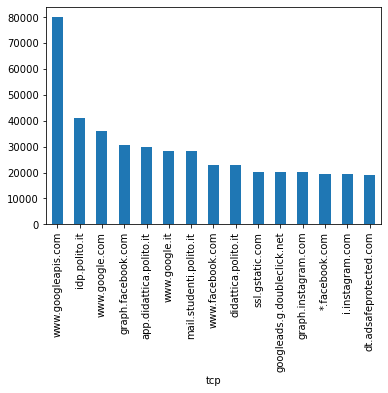

In [3]:
# Read file CSV
df_iter = pd.read_csv('log_tcp_complete.xz', sep=" ", iterator=True, chunksize=100000)
    
top15 = pd.DataFrame()
tmp = pd.DataFrame()

for chunk in df_iter:
    tmp = chunk.apply(find_TCP, axis=1)
    top15 = pd.concat([top15, tmp])
    
# print(top15)
    
top15.columns = ['tcp']
top15_all = top15.groupby(['tcp']).size()
barplot = top15_all.sort_values(ascending=False).head(15).plot(kind='bar')

The result depicted in the picture is not surprising at all: the most number of connections are towards Google (*www.googleapis.com*, *www.google.com*, *www.google.it*) and some of its sub-services; there are plenty of connection to the intranet of Politecnico as well (*app, mail, didattica* and *idp*); the other most numerous TCP connections are towards Facebook services (such as the previously mentioned *graph.facebook*, *graph.instagram* besides *facebook.com*).
We can also notice that is present the service named *dt.ad**safeprotected**.com*: is a dangerous popup page generated by potentially unwanted program. Thus, it is somehow alarming that a potential dangerous service is the in the top-15 services of the Politecnico's network.

The previous analysis was done considering all kind of TCP connections (HTTP, HTTPS, P2P, IMAP4, ecc). If instead the same experiment is repeated considering only the ones exploiting HTTPS we can see that many services decrease their size. In fact some services like *www.google.com* and *graph.facebook.com* lost around 10000 connections which is already a big number considering the network size. 
Moreover, we can observe that the Politecnico intranet services remains unchanged, gaining some positions an indication that who managed our network in 2015 was already providing a good service to students and was privacy-conscious. 
In the end we can also notice that many services present in the previous graph are now absent and are mainly replaced by some other Google sub-services and Outlook login page (*login.live.com*).

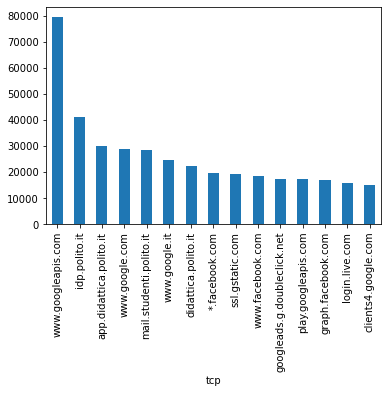

In [4]:
# 15 most used TCP services in general using HTTPS (TLS)

# Read file CSV
df_iter = pd.read_csv('log_tcp_complete.xz', sep=" ", iterator=True, chunksize=100000)
    
top15_tls = pd.DataFrame()
tmp = pd.DataFrame()

for chunk in df_iter:
    # Filter DataFrame for TLS
    tmp = chunk[(chunk['con_t:42'] == 8192)].apply(find_TCP, axis=1)
    top15_tls = pd.concat([top15_tls, tmp])
    
# print(top15_tls)
    
top15_tls.columns = ['tcp']
top15_https = top15_tls.groupby(['tcp']).size()
barplot = top15_https.sort_values(ascending=False).head(15).plot(kind='bar')

### 1.3
We are now asked to analyze the fraction of connections for different "connection type" considering again the whole dataframe without any filtering applied.

Again we iterate over the whole file in order to get all the useful data, which we save in a list. At the end of the reading, all the values stored in the list are summed together and normalized (ignorig NaN values) before being plotted in a barplot.

In [25]:
# Count the fraction of connections for different “connection type”

# Read file CSV
df_iter = pd.read_csv('log_tcp_complete.xz', sep=" ", iterator=True, chunksize=100000)

connections = []

for chunk in df_iter:
    connections.append(chunk.groupby(['con_t:42']).size())
    
# print(connections)

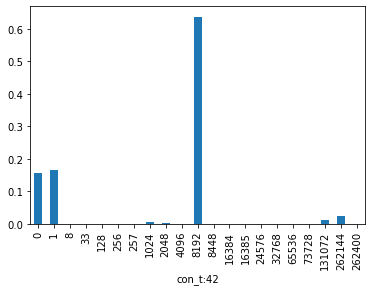

In [60]:
# Normalize and plot
all_connections = sum(connections)
all_connections = all_connections/np.nansum(all_connections)
# print(all_connections)
barplot = all_connections.plot(kind='bar')

From the graph we can observe that more than 60% of the observed traffic use HTTPS (TLS, column 8192 in the graph). This is a good indicator that the most data traffic in the network has at least a level of protection assured by the protocol. However, still 16% of traffic is using the less secure HTTP version (column 1 in the graph).
It can also be oserved that more than 15% of the traffic uses an unknown protocol (column 0) and all the remaining traffic combined has negligible impact: 5% of the whole traffic. Among that 5% the main protocols are the one corresponding to the column 262144 with 2% of traffic, *Bittorrent MSE/PE protocol* (column 131072) with 1% and *SMTP protocol* (column 1024) with 0.05%.

### 1.4
We now try to evaluate the fraction of HTTP, HTTPS and all the others protocols flows and their behavior in time.

As just seen in the previous graph, we expect to have a big difference between HTTPS and HTTP since the first should be around 60% all the time and the second one around 15%. We also expect the sum of all the other protocols to be very low, while the unknown ones to behave similarly to HTTP since previously we observed lower but similar values.

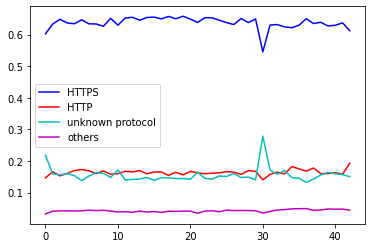

In [73]:
# Count the fraction of protocols flows for each group

# Read file CSV
df_iter = pd.read_csv('log_tcp_complete.xz', sep=" ", iterator=True, chunksize=100000)

rates_HTTP = []
rates_HTTPS = []
rates_unknown = []
rates_other = []
for chunk in df_iter:
    rates_HTTP.append(chunk[(chunk['con_t:42'] == 1)].shape[0]/chunk.shape[0])
    rates_HTTPS.append(chunk[(chunk['con_t:42'] == 8192)].shape[0]/chunk.shape[0])
    rates_unknown.append(chunk[(chunk['con_t:42'] == 0)].shape[0]/chunk.shape[0])
    rates_other.append(chunk[(chunk['con_t:42'] != 8192) & (chunk['con_t:42'] != 1) & (chunk['con_t:42'] != 0)].shape[0]/chunk.shape[0])
    
plt.plot(rates_HTTPS, 'b', label='HTTPS')
plt.plot(rates_HTTP, 'r', label='HTTP')
plt.plot(rates_unknown, 'c', label='unknown protocol')
plt.plot(rates_other, 'm', label='others')
plt.legend()
plt.show()

The plot reflects indeed our preliminary expectations: HTTPS outperforms with respect to all other protocols at around 60%, HTTP and unknown protocols behave similarly and finally all the remaining procols stand at 5%. Observing the graph we can also apppreciate that the overall behavior in time of all the lines is somehow constant.
The interesting part happens with the 30th read chunk: there is a significant decrease of the HTTPS traffic, a small decrease in HTTP and at the same time an increase of around 10% for the traffic of the unknown protocols. Curiously this sudden change becomes negligible already in the very next chunk of data. Probably some sudden event happened in the network that needed a peculiar connection protocol, not identified by *Tstat*. 

ALTRE IDEE?

## Task 2

For this task we were asked to perform more deep and accurate analysis of the file, filtering it according to a web service of our choice, by showing statistics about their usage and the infrastructure each service is using. 
Our choice was to concentrate on **Spotify**.

To meet the requirements for the whole task a filtering on the whole dataset is essential. The first, more logial and immediate choice was to filter according to the string _\*spotify\*_. In such a way we should be able to obtain all the direct Spotify sub-services. Then, a more deep search on the internet suggested some others domains like *open.scdn.co*, *geo3.ggpht.com*, *redirector.gvt1.com* and some others _/*.scdn.co_. Applying a filter also for those domains resulted in complicating all evaluations. Because of the growth of Spotify from 2015 to nowadays (140 million subscribers more in 2021 with respect to 2015) in fact, many domain names have been changed or added.
Therefore we choose to limit ourselves with the main services and sub-services directly likable to Spotify.

Thus, we defined a new method, namely `find_spotify(row)`, to be used within `pandas.DataFrame.apply()` able to filter out all the rows of our interest.
Once determined the filter to be applied, we proceeded to create a local dataframe containing only the rows of our interest. Moreovere, we decided to adopt the same strategy used for Task 1.1, i.e. we added to the local dataframe a new column called *hostname* which contains the result of the filtering process. This is extremely helpful when some manipulation of the dataframe is needed according to the services names.

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

In [4]:
# Define useful method to be used within pandas.DataFrame.apply() method
def find_spotify(row):
    
    string = 'spotify'
    
    if string in row['fqdn:127']:
        return row['fqdn:127']
    
    elif string in row['http_hostname:131']:
        return row['http_hostname:131']
    
    elif string in row['c_tls_SNI:116']:
        return row['c_tls_SNI:116']
    
    else :
        return row['s_tls_SCN:117']
    
# Read file CSV
# dataf = pd.read_csv('log_tcp_complete.xz', sep=' ', nrows=100000)    # used for preliminary results
df_iter = pd.read_csv('log_tcp_complete.xz', sep=" ", iterator=True, chunksize=100000)

# Filter DataFrame for "/*spotify*"
sp_string = '/*spotify*'            # define string to be matched
sp_dataf = pd.DataFrame()           # define new dataframe to be used for evaluations
tmp = pd.DataFrame()                # define support dataframe

for chunk in df_iter:
    tmp = chunk[(chunk['c_isint:38'] == 1) &
                ((chunk['fqdn:127'].str.contains(sp_string)) |
                 (chunk['http_hostname:131'].str.contains(sp_string)) |
                 (chunk['c_tls_SNI:116'].str.contains(sp_string)) |
                 (chunk['s_tls_SCN:117'].str.contains(sp_string))
               )]
    sp_dataf = pd.concat([sp_dataf, tmp])

new_col = sp_dataf.apply(find_spotify, axis=1)
# new_col
sp_dataf.insert(len(sp_dataf.columns), 'hostname', new_col) 

### 2.1

The first result we have to obtain is to identify which are the protocols used by Spotify to communicate with clients.
In order to do so it is sufficient to apply a further filter on the dataframe we extracted from the whole file. We can search for different values in the column named `'con_t:42'` which collects the data we are searching for.
Then, we simply plot them using a descending order barplot.

<AxesSubplot:xlabel='con_t:42'>

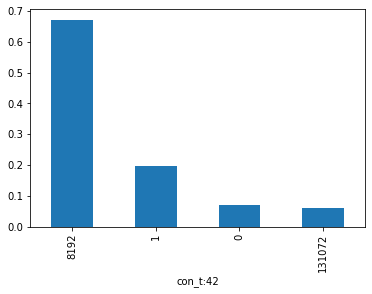

In [6]:
# POINT 5
# group by connection type
protocols = sp_dataf.groupby(['con_t:42']).size()

# normalize values
all_protocols = protocols.sum()
protocols = protocols/all_protocols
# print(protocols)

# plot using barplot
a = protocols.sort_values(ascending=False).plot(kind='bar')

Interestingly, Spotify in 2015 appeared to be using only 4 different protocols for its main services. For the 67% it was using HTTPS and only about 20% of the connections were exploiting HTTP. It is also unusual to see that 6% of the whole Spotify traffic adopted the *Bittorrent MSE/PE protocol* (131072 column) while for nearly 7% of connections it was not possible to identify the protocol used.

### 2.2

Subsequently we were asked to plot the total number of connection per sub-service.
This assignement can be easily solved exploiting the previously created column *hostname* which collects sub-services names.

How many different sub-services?  332


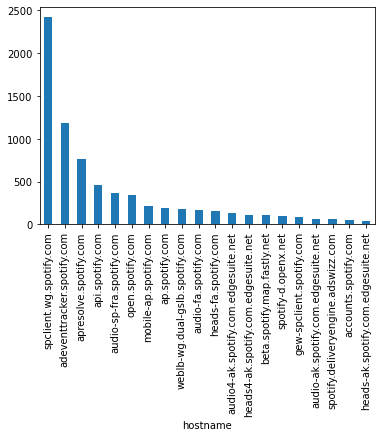

In [7]:
# POINT 6
# group and plot by hostname (sub-services)
sp_hostname_df = sp_dataf.groupby(['hostname']).size()
a = sp_hostname_df.sort_values(ascending=False).head(20).plot(kind='bar')
# print(sp_hostname_df.sort_values(ascending=False).head(20))

print('How many different sub-services? ', sp_hostname_df.value_counts().sum())
# print('What is their name? ')
# services_names = []
# for name in sp_hostname_df.items():
#    services_names.append(name[0])
#    print(name[0])

Somehow unpredictably, we obtained 332 distinct sub-services linked to Spotify.  Anyway, it seems that only the first 6 have are significant in terms of number of connection. Indeed, while the service *spclient.wg.spotify.com* has almost 2500 connections the second  one, *adeventtracker.spotify.com*, has already more than 1200 less! Next, the gap between this last one and *apresolve.spotify.com*, which is the third more numerous is around 400. Below that we are then considering values below 500 and after *open.spotify.com*, which is the 6th largest service, there are only values of connections that starting from around 200 are quickly reaching values below 100 connections per service.

Doing some researches we found that while it is not clear what is *spclient.wg.spotify.com*'s duty, the 2 other most contacted domains are those which allow Spotify to place advertisment in their app or web service (*adeventtracker.spotify.com*) and to verify the subscribers status (*apresolve.spotify.com*). Below the first 3 services we can see the that there are the API service (*api.spotify.com*), the service allowing to actually listen to music (*audio-sp-fra.spotify.com*), the free-to-use web version of Spotify (*open.spotify.com*) and the app for smartphones (*mobile-ap.spotify.com* and *ap.spotify.com*). More further back we can find also other domains used for collecting analytics and used for advertisment purposes.

### 2.3

We now investigate the IP addresses of the service's servers.
It is again simple to filter the dataframe in order to get the desired output.

How many different IP addresses?  342


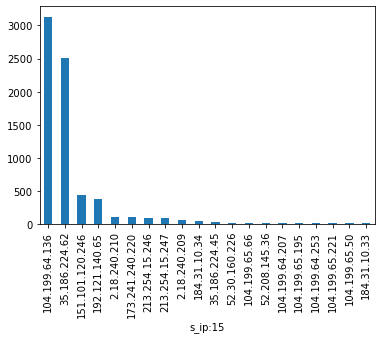

In [8]:
# POINT 7
# group and plot by server IP 
sp_hostname_df = sp_dataf.groupby(['s_ip:15']).size()
a = sp_hostname_df.sort_values(ascending=False).head(20).plot(kind='bar')
# print(sp_hostname_df.sort_values(ascending=False).head(20))

print('How many different IP addresses? ', sp_hostname_df.value_counts().sum())
# print('What is their name? ')
# services_names = []
# for name in sp_hostname_df.items():
#    services_names.append(name[0])
#    print(name[0])

From the plot we notice that more than 70% of the overall TCP connections are ony towards two distinct IP addresses, namely 104.199.64.136 and 35.186.224.62, while the overall number of used addresses is 342, more than the number of sub-services (which are 332).

ALTRO?

### 2.4

Since we discovered that there are more IP addresses than services we analyze how sub-services are mapped to server IPs.

<AxesSubplot:xlabel='hostname'>

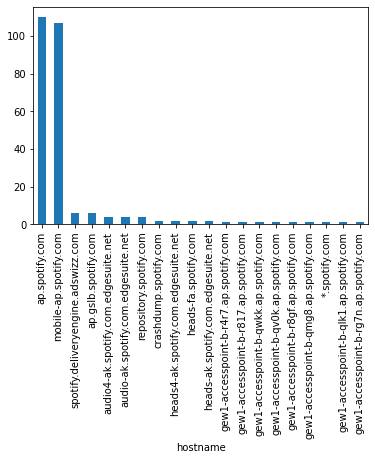

In [9]:
# POINT 8
# Plot the number of distinct server IPs for each subservice
a = sp_dataf.groupby(['hostname'])['s_ip:15'].nunique()\
        .sort_values(ascending=False).head(20).plot(kind='bar')


Again we are in the presence of a particular result: the 38% of all the IP addresses used by all the sub-services are benefit of only two, namely *ap.spotify.com* and *mobile-ap.spotify.com*.

But why there is more than one server IP address per sub-service? NON NE HO IDEA

Moreover, are they all from the same network? 

In [74]:
# che è sta cosa?
# get info on IPs 
s_names = {}
for name in sp_subserv_IPs.items():
    if name[0][0] not in s_names:
        s_names[name[0][0]] = [name[0][1]]
    else:
        if name[0][1] not in s_names[name[0][0]]:
            s_names[name[0][0]].append(name[0][1])
            
for names in s_names:
    print(names)
    for ip in s_names[names]:
        print(ip)


*.spotify.com
104.199.64.136
20.video-ak.cdn.spotify.com
184.31.10.34
4a.video-ak.cdn.spotify.com
184.31.10.34
50.video-ak.cdn.spotify.com
184.31.10.34
8f.video-ak.cdn.spotify.com
184.31.10.34
98.video-ak.cdn.spotify.com
184.31.10.34
a9.video-ak.cdn.spotify.com
184.31.10.34
accounts.spotify.com
104.199.64.136
adeventtracker.spotify.com
104.199.64.136
ap.gslb.spotify.com
104.199.64.142
104.199.64.18
104.199.65.1
104.199.65.226
104.199.65.230
104.199.65.83
ap.spotify.com
104.199.64.114
104.199.64.117
104.199.64.121
104.199.64.126
104.199.64.13
104.199.64.131
104.199.64.141
104.199.64.142
104.199.64.143
104.199.64.148
104.199.64.15
104.199.64.152
104.199.64.153
104.199.64.158
104.199.64.160
104.199.64.170
104.199.64.175
104.199.64.18
104.199.64.180
104.199.64.183
104.199.64.185
104.199.64.188
104.199.64.196
104.199.64.197
104.199.64.200
104.199.64.205
104.199.64.207
104.199.64.219
104.199.64.222
104.199.64.225
104.199.64.23
104.199.64.230
104.199.64.235
104.199.64.237
104.199.64.246
104.1

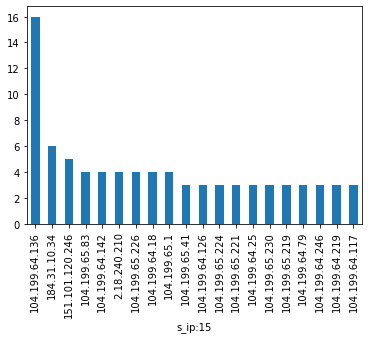

In [11]:
# Point 8.2
# Plot the number of distinct sub-services for each server IP
a = sp_dataf.groupby(['s_ip:15'])['hostname'].nunique().sort_values(ascending=False).head(20).plot(kind='bar')


<AxesSubplot:xlabel='s_ip:15,hostname'>

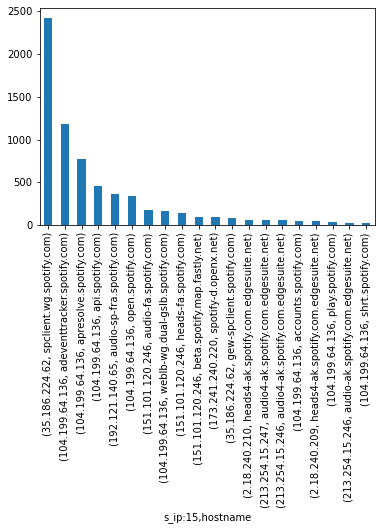

In [12]:
# task 9
a = sp_dataf.groupby(['s_ip:15', 'hostname']).size()\
            .sort_values(ascending=False).head(20).plot(kind='bar')


Task 10
How many distinct clients access the service in total?
How many distinct clients access each server IP address ? Plot in decreasing order the number of clients for
each IP server address (If server IPs are more than 20, plot the top-20).
How many distinct clients access each subservice? Plot in decreasing order the number of clients for each
subservice (If subservices are more than 20, plot the top-20).

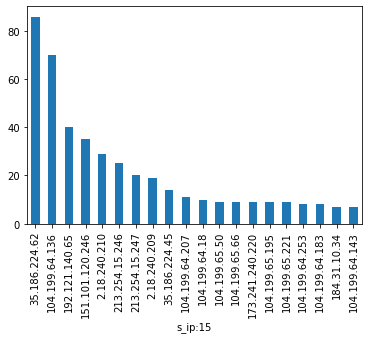

In [12]:
# clients -> local traffic
# part 1
a = sp_dataf[(sp_dataf['c_isint:38'] == 1)].groupby(['s_ip:15'])['#15#c_ip:1']\
            .nunique().sort_values(ascending=False)\
            .head(20).plot(kind='bar')


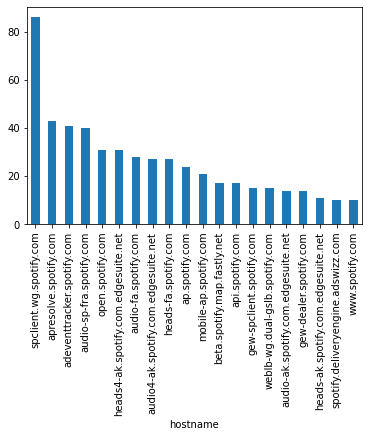

In [13]:
# part 2
a = sp_dataf[(sp_dataf['c_isint:38'] == 1)].groupby(['hostname'])['#15#c_ip:1']\
            .nunique().sort_values(ascending=False)\
            .head(20).plot(kind='bar')

11. How many bytes were exchanged from the clients to the servers (uplink) in total? How many bytes were
exchanged from the servers to the clients (downlink) in total?
Which fraction of the clients exchanged with the service more than 1MB in total (uplink+downlink)?

In [37]:
# 9 c2s 23 s2c
sp_c2s_bytes = sp_dataf['c_bytes_all:9'].sum()
sp_s2c_bytes = sp_dataf['s_bytes_all:23'].sum()
print(sp_c2s_bytes, "Bytes from clients to servers,", sp_s2c_bytes, "Bytes from servers to clients.")

3570616 Bytes from clients to servers, 236165577 Bytes from servers to clients.


12. Count the total number of bytes handled by each server IP address. Compute this separately for the
uplink (client to server) and the downlink (server to client). Plot these two metrics, ordered by decreasing
number of bytes (If server IPs are more than 20, plot the top-20).

Repeat the same for sub-services.

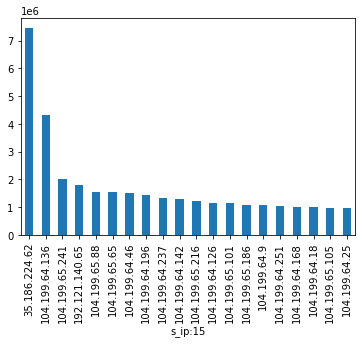

In [14]:
# part 1
a = sp_dataf.groupby(['s_ip:15'])['c_bytes_all:9'].sum()\
        .sort_values(ascending=False).head(20).plot(kind='bar')


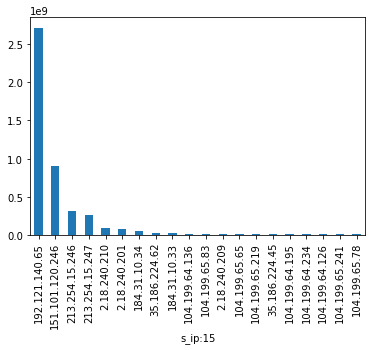

In [15]:
# part 2
a = sp_dataf.groupby(['s_ip:15'])['s_bytes_all:23'].sum()\
            .sort_values(ascending=False).head(20).plot(kind='bar')

# the top 1 could be a local cache, since it appears both on servers and clients

13. For each server IP, extract the minimum of the minimum RTT and average of the average RTT from the
client to the server. Plot them, sorted from the one handling the most clients (see exercise 10), to the least.
(If server IPs are more than 20, plot the top-20) Can you estimate at which distance the servers are? How?

<AxesSubplot:xlabel='s_ip:15'>

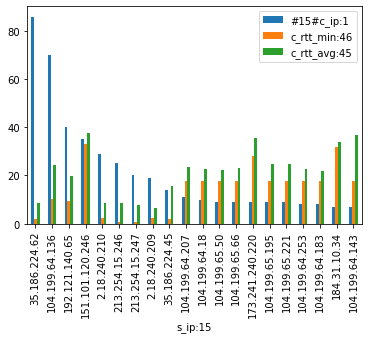

In [17]:
a = sp_dataf[(sp_dataf['c_isint:38'] == 1)]\
        .groupby(['s_ip:15']).agg({'#15#c_ip:1':'nunique', 'c_rtt_min:46':'min', 'c_rtt_avg:45':'mean'})\
        .sort_values('#15#c_ip:1', ascending=False)\
        .head(20).plot(kind='bar')

14. Plot a scatter plot, considering a point for each sub-service, characterized by the number of connections and the number of exchanged bytes each. Are there subservices that handle a lot of connections, but little data? Comment on the plot (you might use log scale for the bytes).

<AxesSubplot:xlabel='n_connections', ylabel='c_bytes_all:9'>

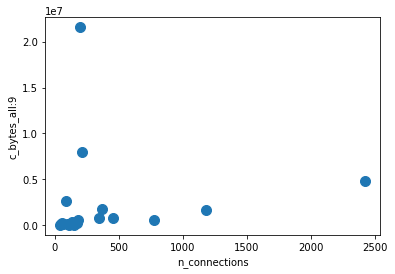

In [17]:
sp_dataf.groupby(['hostname']).agg({'hostname':'size', 'c_bytes_all:9':'sum'})\
        .rename(columns={"hostname": "n_connections"})\
        .sort_values('n_connections', ascending=False).head(20)\
        .plot.scatter(x='n_connections',y='c_bytes_all:9', s=100)
# bisogna mettere la log scale

15. Plot a heatmap representing the number of bytes exchanged between the top-20 most active clients (in terms of number of connections) and the top-20 most contacted sub-services (in terms of number of connections). Select a proper colormap and scale and annotate the cells with whole numbers. Comment on the plot.

<AxesSubplot:xlabel='#15#c_ip:1', ylabel='hostname'>

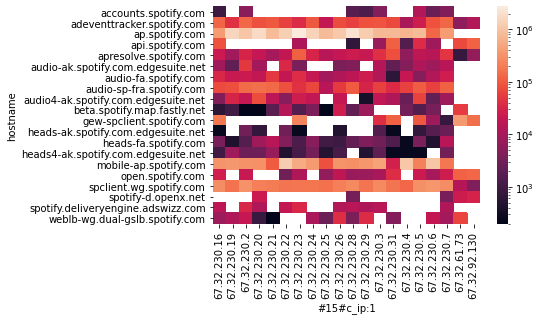

In [18]:
top_clients = sp_dataf.groupby(['#15#c_ip:1']).size().sort_values(ascending=False).head(20)
top_services = sp_dataf.groupby(['hostname']).size().sort_values(ascending=False).head(20)

temp = sp_dataf[(sp_dataf['#15#c_ip:1'].isin(top_clients.keys()) & sp_dataf['hostname'].isin(top_services.keys()))]
table = pd.pivot_table(\
                       temp,\
                       values='c_bytes_all:9', index='hostname', columns='#15#c_ip:1',\
                       aggfunc=np.sum)
#should be the sum of bytes to client and bytes to server?
sns.heatmap(table, norm=LogNorm())

16. For each sub-service, plot a boxplot of the distribution of the fraction of retransmitted packets from the
client to the server and vice-versa. Is there a sub-service with a lot of retransmitted packets? What could be
possible reasons for a large number of retransimissions?

In [29]:
c_rtx = []
s_rtx = []
names = []
for hostname,data in sp_dataf.groupby(['hostname']):
    # filter out meaningless data
    if len(data)<10:   
        continue
    tot_pkts = data['c_pkts_all:3'] + data['s_pkts_all:17']
    c_rtx.append(data['c_pkts_retx:10']/tot_pkts)
    c_rtx.append(data['s_pkts_retx:24']/tot_pkts)
    names.append(hostname)

#plt.figure()
plt.boxplot(c_rtx, figsize =(10, 7))

#plt.figure(figsize =(10, 7))
#plt.boxplot(s_rtx)

TypeError: boxplot() got an unexpected keyword argument 'figsize'

17. Draw the empirical Probability Distribution Function (PDF) and the empirical Cumulative Distribution
Function (CDF) of the RTT (server to client, you can choose between minimum, average or maximum). The
PDF should be estimated either with a histogram or with a proper density estimation. The CDF should be
computed precisely (see lecture slides).

<AxesSubplot:ylabel='Frequency'>

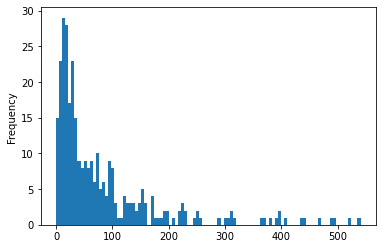

In [21]:
pdf_df = sp_dataf.groupby(['hostname'])['s_rtt_avg:52'].mean()

# filter out outliers
a = pdf_df[(pdf_df < pdf_df.quantile(0.95))].plot.hist(bins=100)


18. Play with the other columns. Which analysis do you think would be interesting? (I) Propose some analyses, (ii) show its results, (iii) comment on the findings.

In [14]:
list(sp_dataf.columns)

['#15#c_ip:1',
 'c_port:2',
 'c_pkts_all:3',
 'c_rst_cnt:4',
 'c_ack_cnt:5',
 'c_ack_cnt_p:6',
 'c_bytes_uniq:7',
 'c_pkts_data:8',
 'c_bytes_all:9',
 'c_pkts_retx:10',
 'c_bytes_retx:11',
 'c_pkts_ooo:12',
 'c_syn_cnt:13',
 'c_fin_cnt:14',
 's_ip:15',
 's_port:16',
 's_pkts_all:17',
 's_rst_cnt:18',
 's_ack_cnt:19',
 's_ack_cnt_p:20',
 's_bytes_uniq:21',
 's_pkts_data:22',
 's_bytes_all:23',
 's_pkts_retx:24',
 's_bytes_retx:25',
 's_pkts_ooo:26',
 's_syn_cnt:27',
 's_fin_cnt:28',
 'first:29',
 'last:30',
 'durat:31',
 'c_first:32',
 's_first:33',
 'c_last:34',
 's_last:35',
 'c_first_ack:36',
 's_first_ack:37',
 'c_isint:38',
 's_isint:39',
 'c_iscrypto:40',
 's_iscrypto:41',
 'con_t:42',
 'p2p_t:43',
 'http_t:44',
 'c_rtt_avg:45',
 'c_rtt_min:46',
 'c_rtt_max:47',
 'c_rtt_std:48',
 'c_rtt_cnt:49',
 'c_ttl_min:50',
 'c_ttl_max:51',
 's_rtt_avg:52',
 's_rtt_min:53',
 's_rtt_max:54',
 's_rtt_std:55',
 's_rtt_cnt:56',
 's_ttl_min:57',
 's_ttl_max:58',
 'p2p_st:59',
 'ed2k_data:60',
 'ed